In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-18 18:40:08.982110: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 18:40:09.049906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 18:40:09.049946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 18:40:09.051753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 18:40:09.062738: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-18 18:40:11.332312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 18:40:11.373470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 18:40:11.373656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
params = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
feats = np.load(feats_path)
print("feats shape: ", feats.shape)

# use laser power and velocity as labels
params = params[:, :2]
print("y shape: ", params.shape)

y = np.concatenate((params, feats[:, 1:3]), axis=1) # L, H
print("y shape: ", y.shape)

y_max = np.max(y, axis=0)
y = y / y_max

# print max of each column
print("max of each column: ", y_max)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
feats shape:  (9587, 8)
y shape:  (9587, 2)
y shape:  (9587, 4)
max of each column:  [2750.   15.  232.  159.]


In [3]:
# shuffle manta and xiris without lossign correspondence y values
indices = np.arange(manta.shape[0])
# seed
np.random.seed(42)
np.random.shuffle(indices)

manta = manta[indices]
xiris = xiris[indices]
y = y[indices]

# split data into train, validation and test
train_split = 0.8
test_split = 0.2

train_split_idx = int(manta.shape[0] * train_split)
test_split_idx = int(manta.shape[0] * test_split)

x_train_manta = manta[:train_split_idx]
x_train_xiris = xiris[:train_split_idx]
y_train = y[:train_split_idx]

x_test_manta = manta[train_split_idx:]
x_test_xiris = xiris[train_split_idx:]
y_test = y[train_split_idx:]

X_train = np.concatenate((x_train_manta, x_train_xiris), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

# shapes
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (15338, 320, 320)
y_train shape:  (15338, 4)


In [4]:
y_test_all = np.concatenate((y_test, y_test), axis=0)

In [5]:
""" # create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
y_encoded = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    y_encoded[:, i] = encode_one_column(y[:, i])
    
# convert to int
y_encoded = y_encoded.astype(int)
y_encoded.shape """

' # create a function to encode y\ndef encode_one_column(y):\n    # create a new array of zeros with the same shape as y\n    encoded_y = np.zeros(y.shape)\n    # get the unique values in y\n    unique_values = np.unique(y)\n    # loop through the unique values\n    for i, value in enumerate(unique_values):\n        # find the indices where y equals the unique value\n        indices = np.where(y == value)\n        # set the indices in encoded_y to i\n        encoded_y[indices] = i\n    return encoded_y\n\n# create new array to store encoded y\ny_encoded = np.zeros(y.shape)\n# loop through each column in y and encode it\nfor i in range(y.shape[1]):\n    y_encoded[:, i] = encode_one_column(y[:, i])\n    \n# convert to int\ny_encoded = y_encoded.astype(int)\ny_encoded.shape '

In [6]:
""" # concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
x = np.concatenate((manta, xiris), axis=0)
y = np.concatenate((y, y), axis=0)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape) 

del manta, xiris, y, x"""
 

' # concatenate manta and xiris images with label y_encoded as rows\n# concatenate the two inputs (manta and xiris) along rows\nx = np.concatenate((manta, xiris), axis=0)\ny = np.concatenate((y, y), axis=0)\nprint("x shape: ", x.shape)\nprint("y shape: ", y.shape)\n\n# split data into train and test (manta as input and y as output) with shuffle as true\nfrom sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)\nprint("x_train shape: ", X_train.shape)\nprint("y_train shape: ", y_train.shape)\nprint("x_test shape: ", X_test.shape)\nprint("y_test shape: ", y_test.shape) \n\ndel manta, xiris, y, x'

In [7]:
""" import tensorflow_addons as tfa

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
num_tasks = 2
 
encoder = create_encoder(input_shape)
# build model
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)
# summarize model
encoder_with_projection_head.summary()

class SupConModel(Model):
    def __init__(self, sup_model, temperature=0.05):
        super().__init__()
        self.sup_model = sup_model
        self.temperature = 0.05
        #self.contrastive_loss = SupervisedContrastiveLoss()
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        # track loss_p and loss_v
        self.loss_p_tracker = tf.keras.metrics.Mean(name="loss_p")
        self.loss_v_tracker = tf.keras.metrics.Mean(name="loss_v")


    def call(self, inputs):
        return self.sup_model(inputs)

    def train_step(self, data):
        # Unpack the data
        X, y = data  
        #print(y) y is (none, 2)
        y_p = y[:, 0]
        y_v = y[:, 1]
        
        with tf.GradientTape() as tape:
            y_pred = self.sup_model(X) # Forward pass
            #print(y_pred[0].shape); #print(y_p.shape)
            # compute loss
            loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
            loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
            loss = loss_p + loss_v
            
        # Storing the gradients of the loss function with respect to the weights/parameters.
        gradients = tape.gradient(loss, self.sup_model.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.sup_model.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
   
        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(), "loss_v": self.loss_v_tracker.result()}

    def test_step(self, data): # model.evaluate() stores the losses and metrics in a list
        # Unpack the data
        X, y = data
        y_p = y[:, 0]
        y_v = y[:, 1]
               
        # Compute predictions
        y_pred = self.sup_model(X, training=False)
        # The loss is computed on the test set
        loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
        loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
        loss = loss_p + loss_v
        
        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)

        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(), "loss_v": self.loss_v_tracker.result()}
    
    def supervised_contrastive_loss(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]
    
model = SupConModel(encoder_with_projection_head, temperature=0.05)

# Compile the model
learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
)

batch_size = 64
epochs = 1

# Train the model
model.fit(
    x=X_train, 
    # y is only the first 2 columns of the labels
    y=y_train[:, :2],
    batch_size=batch_size, epochs=epochs, validation_split=0.2,) """

' import tensorflow_addons as tfa\n\ndef create_encoder(input_shape=(320, 320, 1)):\n    inputs = Input(shape=input_shape)\n    x = Conv2D(16, (3, 3), activation=\'relu\')(inputs)\n    x = MaxPooling2D((2, 2))(x)\n    x = Conv2D(32, (3, 3), activation=\'relu\')(x)\n    x = MaxPooling2D((2, 2))(x)\n    x = Conv2D(64, (3, 3), activation=\'relu\')(x)\n    x = MaxPooling2D((2, 2))(x)\n    x = Flatten()(x)\n    x = Dense(128, activation=\'relu\')(x)\n    \n    model = Model(inputs=inputs, outputs=x)\n    return model\n\n# add projection head\ndef add_projection_head(input_shape, encoder, embedding_dim):\n    inputs = Input(shape=input_shape)\n    features = encoder(inputs)\n    \n    contrastive_outputs = [Dense(embedding_dim, activation=\'linear\', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]\n\n    model = Model(inputs=inputs, outputs=contrastive_outputs)\n    return model\n\ninput_shape = (320, 320, 1)\nembedding_dim = 128\nnum_tasks = 2\n \nencoder = create_encod

In [8]:
import tensorflow as tf
import tensorflow_addons as tfa

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

def add_projection_head(input_shape, encoder, embedding_dim, regression_dim=1):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    # Add regression head
    regression_outputs = [Dense(regression_dim, activation='linear', name=f"regression_output_{i}")(output) for i, output in enumerate(contrastive_outputs)]

    model = Model(inputs=inputs, outputs=contrastive_outputs + regression_outputs)
    return model

class SupConModel(Model):
    def __init__(self, sup_model, temperature=0.05):
        super().__init__()
        self.sup_model = sup_model
        self.temperature = 0.05
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.loss_p_tracker = tf.keras.metrics.Mean(name="loss_p")
        self.loss_v_tracker = tf.keras.metrics.Mean(name="loss_v")
        self.loss_reg_tracker = tf.keras.metrics.Mean(name="loss_reg")

    def call(self, inputs):
        return self.sup_model(inputs)

    def train_step(self, data):
        X, y = data

        with tf.GradientTape() as tape:
            y_pred = self.sup_model(X)
            loss_p = self.supervised_contrastive_loss(y[:, 0], y_pred[0])
            loss_v = self.supervised_contrastive_loss(y[:, 1], y_pred[1])
            
            loss_reg_p = tf.keras.losses.MSE(y[:, 0], y_pred[2])
            loss_reg_v = tf.keras.losses.MSE(y[:, 1], y_pred[3])
            loss = loss_p + loss_v + loss_reg_p + loss_reg_v

        gradients = tape.gradient(loss, self.sup_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.sup_model.trainable_weights))

        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
        self.loss_reg_tracker.update_state(loss_reg_p + loss_reg_v)

        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(),
                "loss_v": self.loss_v_tracker.result(), "loss_reg": self.loss_reg_tracker.result()}

    def test_step(self, data):
        X, y = data
        y_p = y[:, 0]
        y_v = y[:, 1]

        y_pred = self.sup_model(X, training=False)
        loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
        loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
        loss_reg_p = tf.keras.losses.MSE(y_p, y_pred[2])
        loss_reg_v = tf.keras.losses.MSE(y_v, y_pred[3])
        loss = loss_p + loss_v + loss_reg_p + loss_reg_v

        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
        self.loss_reg_tracker.update_state(loss_reg_p + loss_reg_v)

        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(),
                "loss_v": self.loss_v_tracker.result(), "loss_reg": self.loss_reg_tracker.result()}

    def supervised_contrastive_loss(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

    @property
    def metrics(self):
        return [self.loss_tracker]

input_shape = (320, 320, 1)
embedding_dim = 128
regression_dim = 1
num_tasks = 2  # Number of contrastive tasks

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim, regression_dim)
encoder_with_projection_head.summary()
    
model = SupConModel(encoder_with_projection_head, temperature=0.05)
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

batch_size = 64
epochs = 10

history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)




/home/vm/laser/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-01-18 18:40:27.888632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 18:40:27.888836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negativ

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  1185267   ['input_2[0][0]']             
                                                          2                                       
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  16512     ['model[0][0]']               
 e)                                                                                               
                                                                                            

2024-01-18 18:40:41.641172: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-18 18:40:41.875198: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 18:40:42.504671: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 18:40:44.291489: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe1bf5f31c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 18:40:44.291554: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-18 18:40:44.309140: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705603244.545297 1602961 device_compiler.h:186] 

192/192 [==============================] - 24s 76ms/step - loss: 7.8693 - loss_p: 3.8153 - loss_v: 4.1797 - loss_reg: 0.2403 - val_loss: 7.6346 - val_loss_p: 3.5102 - val_loss_v: 4.1223 - val_loss_reg: 0.1883
Epoch 2/10
192/192 [==============================] - 9s 45ms/step - loss: 6.8965 - loss_p: 3.3998 - loss_v: 4.0203 - loss_reg: 0.1874 - val_loss: 6.7424 - val_loss_p: 3.2694 - val_loss_v: 3.8817 - val_loss_reg: 0.1917
Epoch 3/10
192/192 [==============================] - 9s 46ms/step - loss: 6.5222 - loss_p: 3.2161 - loss_v: 3.8099 - loss_reg: 0.1897 - val_loss: 6.4766 - val_loss_p: 3.1543 - val_loss_v: 3.7236 - val_loss_reg: 0.1881
Epoch 4/10
192/192 [==============================] - 9s 45ms/step - loss: 6.4058 - loss_p: 3.1256 - loss_v: 3.6809 - loss_reg: 0.1863 - val_loss: 6.3924 - val_loss_p: 3.0875 - val_loss_v: 3.6269 - val_loss_reg: 0.1856
Epoch 5/10
192/192 [==============================] - 9s 45ms/step - loss: 6.3485 - loss_p: 3.0686 - loss_v: 3.5979 - loss_reg: 0.1842

Text(0, 0.5, 'Loss')

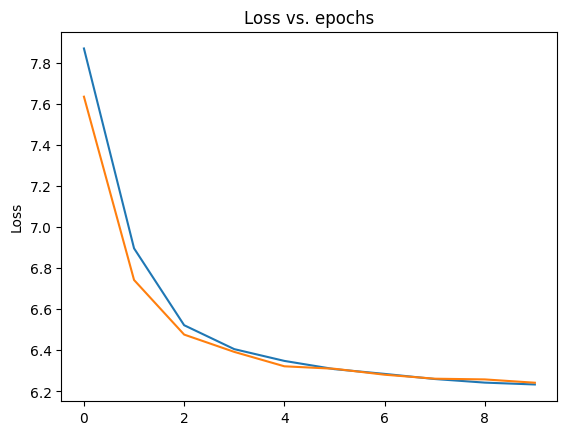

In [9]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs. epochs")
plt.ylabel("Loss")

In [10]:
for i, layer in enumerate(model.sup_model.layers):
    print(i, layer.name)

0 input_2
1 model
2 contrastive_output_0
3 contrastive_output_1
4 regression_output_0
5 regression_output_1


In [11]:
# Create a new model by copying the architecture
new_model = Model(inputs=model.sup_model.input, outputs=[model.sup_model.layers[2].output, model.sup_model.layers[3].output])
# remove layer 4 and 5
new_model.summary()

# set weights of new model to weights of trained model for each layer except the last 2 layers
for layer in new_model.layers:
    layer.set_weights(model.sup_model.get_layer(layer.name).get_weights())
    print(layer.name, "weights set")
    layer.trainable = False
    

inputs = Input(shape=(320, 320, 1))
x = new_model(inputs)
# merge the last 2 layers in a single layer
x = layers.concatenate(x)
# add a two regression heads
#x = Dense(128, activation='relu')(x)
output_l = Dense(1, activation="linear", name="lenght")(x)
output_h = Dense(1, activation="linear", name="height")(x)

model_3 = Model(inputs=inputs, outputs=[output_l, output_h])
model_3.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  1185267   ['input_2[0][0]']             
                                                          2                                       
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  16512     ['model[0][0]']               
 e)                                                                                               
                                                                                            

input_2 weights set
model weights set
contrastive_output_0 weights set
contrastive_output_1 weights set
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 128),                1188569   ['input_3[0][0]']             
                              (None, 128)]                6                                       
                                                                                                  
 concatenate (Concatenate)   (None, 256)                  0         ['model_2[0][0]',             
                                                                     'model_2[0][1]']  

In [12]:
# fit model
learning_rate = 0.0001
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

batch_size = 64
epochs = 10

history = model_3.fit(x=X_train, 
            y=[y_train[:, 2], y_train[:, 3]],
            #y=y_train[:, 2:], # L, H
            batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/10
192/192 [==============================] - 10s 45ms/step - loss: 0.4902 - lenght_loss: 0.3877 - height_loss: 0.1025 - val_loss: 0.3713 - val_lenght_loss: 0.3067 - val_height_loss: 0.0645
Epoch 2/10
192/192 [==============================] - 6s 30ms/step - loss: 0.2612 - lenght_loss: 0.2258 - height_loss: 0.0354 - val_loss: 0.2068 - val_lenght_loss: 0.1825 - val_height_loss: 0.0243
Epoch 3/10
192/192 [==============================] - 6s 31ms/step - loss: 0.1403 - lenght_loss: 0.1280 - height_loss: 0.0123 - val_loss: 0.1193 - val_lenght_loss: 0.1081 - val_height_loss: 0.0112
Epoch 4/10
192/192 [==============================] - 6s 30ms/step - loss: 0.0796 - lenght_loss: 0.0733 - height_loss: 0.0062 - val_loss: 0.0736 - val_lenght_loss: 0.0662 - val_height_loss: 0.0074
Epoch 5/10
192/192 [==============================] - 6s 31ms/step - loss: 0.0494 - lenght_loss: 0.0446 - height_loss: 0.0048 - val_loss: 0.0496 - val_lenght_loss: 0.0435 - val_height_loss: 0.0061
Epoch 6/10
192

In [13]:
X_test = np.concatenate((x_test_manta, x_test_xiris), axis=0)
y_test = np.concatenate((y_test, y_test), axis=0)

# print shapes
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_test shape:  (3836, 320, 320)
y_test shape:  (3836, 4)


In [14]:
score = model_3.evaluate(X_test, [y_test[:, 2], y_test[:, 3]], verbose=0)
print(score)

[0.020759407430887222, 0.015910910442471504, 0.004848495591431856]


120/120 [==============================] - 1s 10ms/step
r2 score:  0.7073289314812958 0.585209952142494


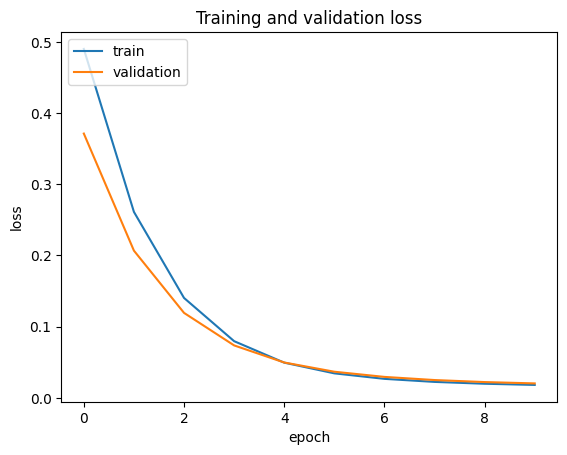

In [15]:
# eval regression model
from sklearn.metrics import r2_score

y_pred_l, y_pred_h = model_3.predict(X_test)
r2_l = r2_score(y_test[:,2], y_pred_l)
r2_h = r2_score(y_test[:,3], y_pred_h)
print("r2 score: ", r2_l, r2_h)

# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [16]:
X_test_new = x_test_manta
print(X_test_new.shape)


# y_test_new is half of the rows of y_test
y_test_new = y_test[:len(y_test)//2, :] # ALTERAR!! !!!!!!! 
print(y_test_new.shape)

(1918, 320, 320)
(1918, 4)


In [17]:
y_pred_l_new, y_pred_h_new = model_3.predict(X_test_new)
r2_l_new = r2_score(y_test_new[:,2], y_pred_l_new)
r2_h_new = r2_score(y_test_new[:,3], y_pred_h_new)

print("r2 score: ", r2_l_new, r2_h_new)

60/60 [==============================] - 1s 14ms/step
r2 score:  0.7452021151412433 0.6758290262432732


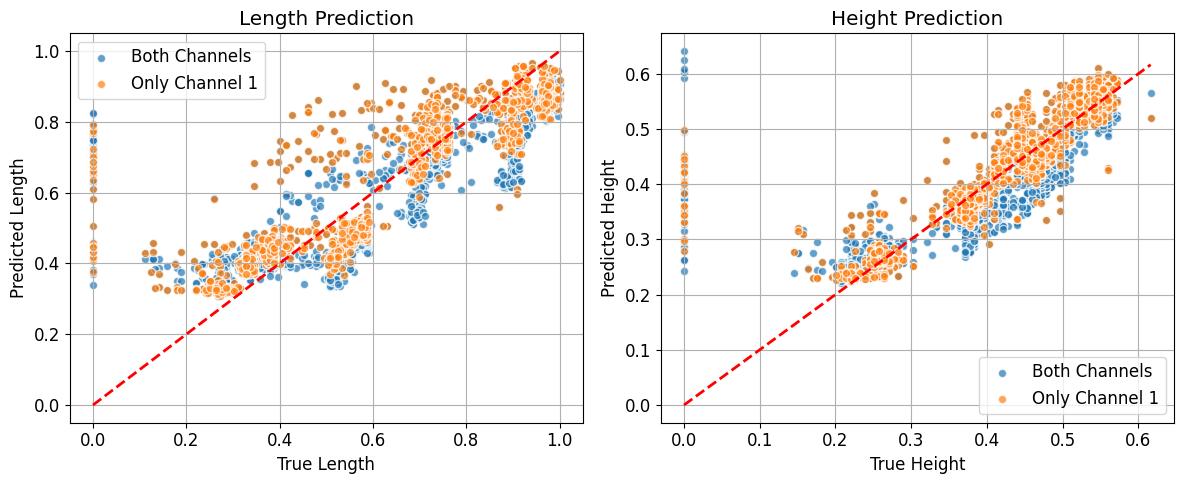

In [18]:
import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 2], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test_new[:, 2], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 2]), max(y_test[:, 2])], [min(y_test[:, 2]), max(y_test[:, 2])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 3], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test_new[:, 3], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 3]), max(y_test[:, 3])], [min(y_test[:, 3]), max(y_test[:, 3])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
X_test.shape

(3836, 320, 320)

In [22]:
X_test_new.shape

(1918, 320, 320)

Layer name: concatenate
120/120 [==============================] - 1s 9ms/step


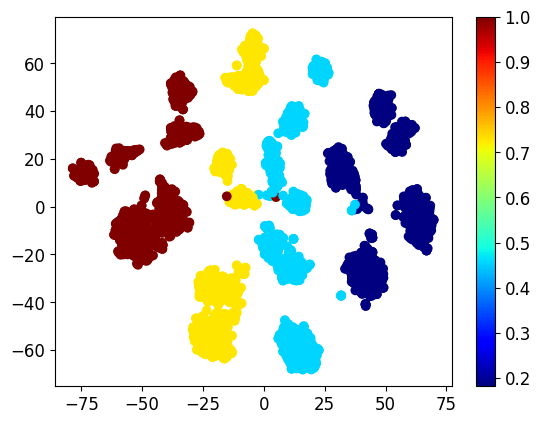

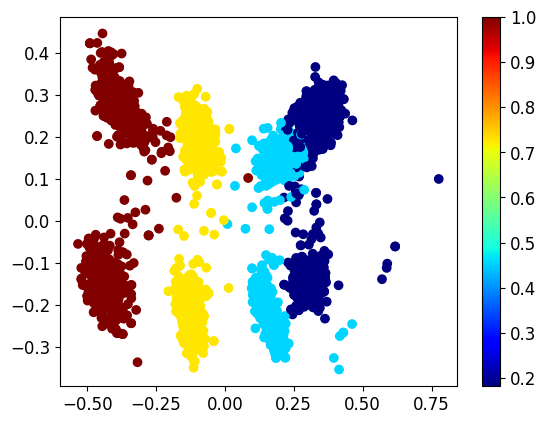

Layer name: concatenate
60/60 [==============================] - 1s 9ms/step


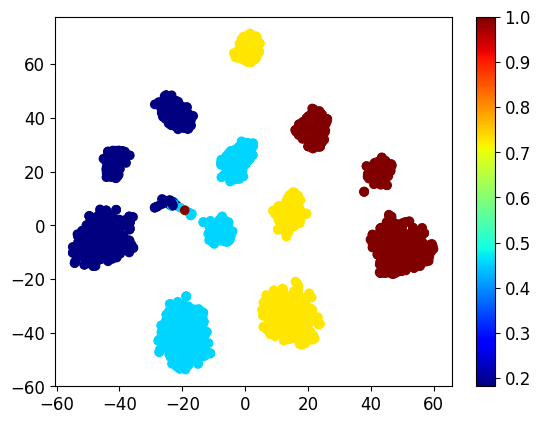

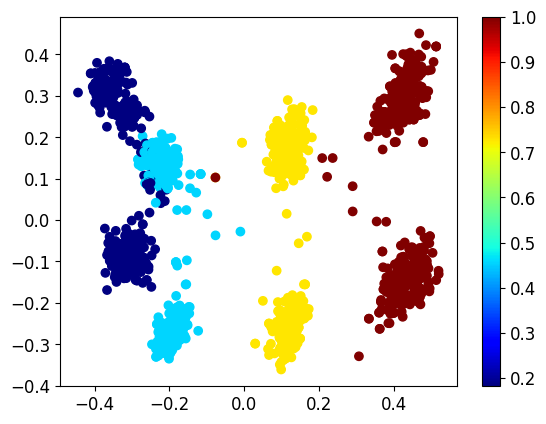

(array([[ 23.556452 ,  37.92616  ],
        [ -5.888482 ,  -4.060903 ],
        [ 42.971455 ,  -5.81884  ],
        ...,
        [  9.566414 , -41.264374 ],
        [-36.12307  ,  -7.3464923],
        [ 51.583927 ,   1.2629229]], dtype=float32),
 array([[ 0.45409632,  0.36737108],
        [-0.22018608,  0.11614725],
        [ 0.4636177 , -0.09563254],
        ...,
        [ 0.12421335, -0.27027658],
        [-0.25619003, -0.11950367],
        [ 0.44215447, -0.15519533]], dtype=float32))

In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE or PCA
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    # apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model_3, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)

eval_tsne_pca(model_3, n_layer=N_LAYER, x_test=X_test_new, y_test=y_test_new, plot=True)

# eval for X_test_new
